# for testing

In [1]:
# Comment: Import everything we need for this test notebook.
import os
import numpy as np
import pandas as pd
import pickle

from data_loading.gather_mat_files_multiple import gather_mat_files_multiple_condition
from data_loading.load_intervals import load_intervals_data
from data_loading.load_scores import load_scores_data
from data_loading.load_postprocessed import load_postprocessed_data

# Comment: Define the base folder that contains your multiple-condition subfolders.
base_folder = r"D:\behavior_ethogram_project_Ilya"


In [2]:

# Comment: 2) Gather .mat files for all conditions found under the base_folder
all_condition_files, condition_names = gather_mat_files_multiple_condition([base_folder])


# Comment: 4) Load postprocessed (binary) data for each condition/behavior combination.
all_flies_post, post_index_map, post_cond_names = load_postprocessed_data(
    all_condition_files,
    single=False,
    condition_names=condition_names
)
# Comment: 3) Load continuous scores data. This function normalizes each fly's data
#            by the per-file (behavior) scoreNorm. We want to preserve the raw
#            scoreNorm values as well. For that, we can store them separately
#            (the code below shows how to collect them after calling load_scores_data).
all_flies_scores, scores_index_map, scores_cond_names = load_scores_data(
    all_condition_files,
    single=False,
    condition_names=condition_names
)

# Comment: The "load_scores_data" function in its current form normalizes the data in-place
#          but doesn't store the raw scoreNorm values for external reference.
#          If you want the actual float for each .mat file, you can modify that function to
#          return them or to store them in a global structure. For demonstration, here's an
#          approach that 'hooks' into your existing single-condition loader to gather them.


In [3]:
# Comment: 5) Example snippet to "hook" into the load_scores_data logic and collect scoreNorms.
#            We'll replicate the logic of _load_single_condition_scores, but store the norms.

from scipy.io import loadmat

def gather_scoreNorms(all_condition_files):
    """
    Collect the raw scoreNorm values from each .mat file in each condition.
    Returns a list-of-lists parallel to all_condition_files, containing float scoreNorms.
    """
    norms_per_condition = []
    for cond_idx, file_list in enumerate(all_condition_files):
        cond_norms = []
        for mf in file_list:
            mat_data = loadmat(mf, struct_as_record=False, squeeze_me=True)['allScores']
            if not hasattr(mat_data, 'scoreNorm'):
                cond_norms.append(None)
            else:
                cond_norms.append(float(mat_data.scoreNorm))
        norms_per_condition.append(cond_norms)
    return norms_per_condition

score_norms = gather_scoreNorms(all_condition_files)

# Comment: Now 'score_norms' is a parallel structure to all_condition_files:
#     score_norms[c_idx][b_idx] is the float norm for that condition c_idx, behavior b_idx.
score_norms


[[170.20867733940753], [170.20867733940753]]

In [4]:
# Comment: 6) Display a quick table of scoreNorms for each condition (row) and each behavior (column).
#            We'll assume each condition has the same number of behaviors for a tidy DataFrame.
df_norms = pd.DataFrame(score_norms, index=scores_cond_names)
df_norms.columns = [f"Behavior_{i}" for i in range(df_norms.shape[1])]
df_norms


,Behavior_0
Assa_Females_Mated_Unknown_RigA_20220207T130211,170.208677
Assa_Females_Singles_Unknown_RigA_20220206T100525,170.208677


In [5]:
# Comment: 7) For demonstration, let's pick the "last loaded fly" from the scores and
#            show its shape, then gather some summary stats (like max in each column).
last_fly_scores = all_flies_scores[-1]  # (T,B) array
print("Last fly scores shape:", last_fly_scores.shape)

score_summaries = []
if last_fly_scores.ndim == 2:
    B = last_fly_scores.shape[1]
    for b_idx in range(B):
        col_data = last_fly_scores[:, b_idx]
        valid = col_data[~np.isnan(col_data)]
        max_val = valid.max() if len(valid) else np.nan
        mean_val = valid.mean() if len(valid) else np.nan
        score_summaries.append({
            "BehaviorIndex": b_idx,
            "MaxScore": max_val,
            "MeanScore": mean_val
        })
df_score_summary = pd.DataFrame(score_summaries)
df_score_summary


Last fly scores shape: (27003, 11)


,BehaviorIndex,MaxScore,MeanScore
0,0,1.612460,0.006987
1,1,1.252306,-0.807920
2,2,1.052559,-0.933055
3,3,0.798297,-0.761732
4,4,0.664500,-0.874180
5,5,1.047092,-0.740693
6,6,1.000000,-0.896570
7,7,1.204486,0.278284
8,8,1.514454,-0.813499
9,9,0.923359,-0.546976


In [6]:
# Comment: 8) Similarly, we can examine the last loaded fly's postprocessed data
#            and see how many 1's and 0's appear in each column.
last_fly_post = all_flies_post[-1]  # (T,B) array
binary_stats = []
if last_fly_post.ndim == 2:
    B = last_fly_post.shape[1]
    for b_idx in range(B):
        col = last_fly_post[:, b_idx]
        col_no_nan = col[~np.isnan(col)]
        num_ones  = np.sum(col_no_nan == 1)
        num_zeros = np.sum(col_no_nan == 0)
        binary_stats.append({
            "BehaviorIndex": b_idx,
            "Count1": int(num_ones),
            "Count0": int(num_zeros)
        })
df_binary = pd.DataFrame(binary_stats)
df_binary


,BehaviorIndex,Count1,Count0
0,0,14127,12876
1,1,162,26841
2,2,824,26179
3,3,2582,24421
4,4,241,26762
5,5,3675,23328
6,6,329,26674
7,7,16188,10815
8,8,3077,23926
9,9,1381,25622


In [10]:

# 9) Capture behavior names by parsing filenames for each condition
behavior_names_per_condition = []
for cond_files in all_condition_files:
    # cond_files is a list of .mat filepaths for a single condition
    names_for_this_cond = []
    for filepath in cond_files:
        base = os.path.basename(filepath)            # e.g. "scores_Grooming.mat"
        no_ext = os.path.splitext(base)[0]           # e.g. "scores_Grooming"
        # behavior name is everything after first underscore, or if multiple underscores, up to user logic
        # example: "scores_Grooming" => "Grooming"
        parts = no_ext.split("_", 1)  # split once on first '_'
        if len(parts) == 2:
            behavior_name = parts[1]  # e.g. "Grooming"
        else:
            behavior_name = no_ext   # fallback if unexpected format
        names_for_this_cond.append(behavior_name)
    behavior_names_per_condition.append(names_for_this_cond)

# 2) Create a dictionary of everything you want to export
export_data = {
    "postprocessed_data": all_flies_post,        # global list of postprocessed (T,B) arrays
    "index_map": post_index_map,
    "condition_names": post_cond_names,
    "behavior_names_per_condition": behavior_names_per_condition
}

# 3) Save this to a pickle in your base_folder
export_path = os.path.join(base_folder, "postprocessed_data.pkl")
with open(export_path, "wb") as f:
    pickle.dump(export_data, f)

print(f"Postprocessed data (with behavior names) saved to {export_path}")

Postprocessed data (with behavior names) saved to D:\behavior_ethogram_project_Ilya\postprocessed_data.pkl


EXPORT TO CSV

In [3]:
import os
import scipy.io as spio
import mat73
import numpy as np
import pandas as pd
import sys

def _dict2list_of_dicts(input_dict):
    """
    Transposes a dictionary of lists to a list of dictionaries.
    """
    keys = list(input_dict.keys())
    length = len(input_dict[keys[0]])
    output_list = []
    for i in range(length):
        temp_dict = {key: input_dict[key][i] for key in keys}
        output_list.append(temp_dict)
    return output_list

def _listofdicts_clean_scalar_arrays(listofdicts):
    """
    Cleans scalar arrays by converting numpy arrays of shape () to numeric values.
    """
    def _scalar_array2num(value):
        if isinstance(value, np.ndarray) and value.shape == ():
            scalar_value = value.item()
            if isinstance(scalar_value, float) and scalar_value.is_integer():
                return int(scalar_value)
            return scalar_value
        return value

    output_list = []
    for dictionary in listofdicts:
        output_dict = {}
        for key, value in dictionary.items():
            output_dict[key] = _scalar_array2num(value)
        output_list.append(output_dict)
    return output_list

class struct2df():
    def __init__(self, matfile):
        """
        Initializes the struct2df object by loading and processing the .mat file.
        Extracts scores, processed scores, behavior name, and scoreNorm if available.
        """
        try:
            self.mat_dict = spio.loadmat(matfile, simplify_cells=True)
        except NotImplementedError:
            self.mat_dict = mat73.loadmat(matfile)
            if 'trx' in self.mat_dict:
                temp_ls_of_dicts = _dict2list_of_dicts(self.mat_dict['trx'])
                self.mat_dict['trx'] = _listofdicts_clean_scalar_arrays(temp_ls_of_dicts)

        self.scores = pd.DataFrame()
        self.processed_scores = pd.DataFrame()
        self.behavior_name = ''
        self.dtype = ''
        self.scoreNorm = None  # Initialize scoreNorm

        if 'allScores' in self.mat_dict.keys():
            self.dtype = 'scores'
            self.behavior_name = (os.path.basename(matfile)).replace('.mat', '').replace("scores_", "")
            scores_dict = {}
            postprocessed_dict = {}
            for idx in range(len(self.mat_dict['allScores']['scores'])):
                scores_dict.update({idx+1: self.mat_dict['allScores']['scores'][idx]})
                postprocessed_dict.update({idx+1: self.mat_dict['allScores']['postprocessed'][idx]})
            self.scores = pd.DataFrame(scores_dict)
            self.processed_scores = pd.DataFrame(postprocessed_dict)

        # Extract scoreNorm if available
        if 'scoreNorm' in self.mat_dict:
            try:
                self.scoreNorm = float(self.mat_dict['scoreNorm'])
            except (TypeError, ValueError):
                self.scoreNorm = np.nan
        elif 'allScores' in self.mat_dict and 'scoreNorm' in self.mat_dict['allScores']:
            try:
                self.scoreNorm = float(self.mat_dict['allScores']['scoreNorm'])
            except (TypeError, ValueError):
                self.scoreNorm = np.nan
        else:
            self.scoreNorm = np.nan  # or set a default value if appropriate

    def save_perframe_or_behavior(self, name=''):
        """
        Saves scores and processed scores to CSV files.
        """
        if self.dtype == 'scores':
            self.scores.to_csv(f"{name}_{self.behavior_name}_scores.csv", index=False)
            self.processed_scores.to_csv(f"{name}_{self.behavior_name}_processed_scores.csv", index=False)

def export_all_scores_to_csv(all_condition_files, condition_names, out_csv):
    """
    Reads each scores_*.mat in all_condition_files, merges them into one long table with:
      - Condition name
      - Behavior name
      - Fly ID
      - Frame index
      - Score
      - ProcessedScore
      - scoreNorm
    Saves the combined table to out_csv.

    Parameters:
    - all_condition_files: List of lists of paths to scores_*.mat files.
    - condition_names: List of condition names corresponding to each sublist.
    - out_csv: Path to the output CSV file.
    """
    combined = []
    for condition_files, cond_name in zip(all_condition_files, condition_names):
        for mat_path in condition_files:
            # Ensure mat_path is a string
            if not isinstance(mat_path, str):
                print(f"Skipping file {mat_path}: Path is not a string.")
                continue

            # Check if file exists
            if not os.path.isfile(mat_path):
                print(f"Skipping file {mat_path}: File does not exist.")
                continue

            s2df = struct2df(mat_path)

            # Check if scores and processed_scores are available
            if s2df.dtype != 'scores':
                print(f"Skipping file {mat_path}: Not a scores type mat file.")
                continue

            # Melt scores to long format
            scores_long = s2df.scores.reset_index().melt(
                id_vars='index', var_name='FlyID', value_name='Score'
            )
            scores_long.rename(columns={'index': 'Frame'}, inplace=True)

            # Melt processed_scores to long format
            proc_long = s2df.processed_scores.reset_index().melt(
                id_vars='index', var_name='FlyID', value_name='ProcessedScore'
            )
            proc_long.rename(columns={'index': 'Frame'}, inplace=True)

            # Merge scores and processed_scores on Frame and FlyID
            merged = pd.merge(scores_long, proc_long, on=['Frame', 'FlyID'], how='outer')

            # Add Condition and Behavior columns
            merged['Condition'] = cond_name
            merged['Behavior'] = s2df.behavior_name

            # Add scoreNorm column if available
            if not pd.isna(s2df.scoreNorm):
                merged['scoreNorm'] = s2df.scoreNorm
            else:
                merged['scoreNorm'] = np.nan  # or handle as needed

            combined.append(merged)

    # Concatenate all merged dataframes
    if combined:
        final_df = pd.concat(combined, ignore_index=True)
        final_df.to_csv(out_csv, index=False)
        print(f"Exported combined CSV to {out_csv}")
    else:
        print("No data to export.")

# Example usage:
if __name__ == "__main__":
    # Define your base folder
    base_folder = r"D:\behavior_ethogram_project_Ilya"

    # Gather all scores_*.mat files and their condition names
    try:
        all_condition_files, condition_names = gather_mat_files_multiple_condition([base_folder])
    except RuntimeError as e:
        print(f"Error during file gathering: {e}")
        sys.exit(1)

    # Debug: Print gathered files and conditions
    print("Gathered Mat Files:")
    for idx, files in enumerate(all_condition_files):
        print(f"Condition '{condition_names[idx]}' has {len(files)} file(s):")
        for file in files:
            print(f"  - {file}")
    print("\n")

    # Define the output CSV path
    out_csv = r"D:\behavior_ethogram_project_Ilya\output_combined_scores.csv"

    # Export all scores to CSV
    export_all_scores_to_csv(all_condition_files, condition_names, out_csv)


Gathered Mat Files:
Condition 'Assa_Females_Mated_Unknown_RigA_20220207T130211' has 11 file(s):
  - D:\behavior_ethogram_project_Ilya\Assa_Females_Mated_Unknown_RigA_20220207T130211\scores_Grooming.mat
  - D:\behavior_ethogram_project_Ilya\Assa_Females_Mated_Unknown_RigA_20220207T130211\scores_Jump.mat
  - D:\behavior_ethogram_project_Ilya\Assa_Females_Mated_Unknown_RigA_20220207T130211\scores_Long_Distance_Approach.mat
  - D:\behavior_ethogram_project_Ilya\Assa_Females_Mated_Unknown_RigA_20220207T130211\scores_Long_Lasting_Interaction.mat
  - D:\behavior_ethogram_project_Ilya\Assa_Females_Mated_Unknown_RigA_20220207T130211\scores_Short_Distance_Approach.mat
  - D:\behavior_ethogram_project_Ilya\Assa_Females_Mated_Unknown_RigA_20220207T130211\scores_Social_Clustering.mat
  - D:\behavior_ethogram_project_Ilya\Assa_Females_Mated_Unknown_RigA_20220207T130211\scores_Stable_Interaction.mat
  - D:\behavior_ethogram_project_Ilya\Assa_Females_Mated_Unknown_RigA_20220207T130211\scores_Stop.mat


In [15]:
print(gather_mat_files_multiple_condition([base_folder]))

([], [])


DATA CLUSTERING

In [2]:
import matplotlib.pyplot as plt

# SciPy and scikit-learn for clustering and visualization
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from data_loading.unify_lengths import unify_lengths
import matplotlib.patches as mpatches
# Distance function imports
from distance_calculation.approach1_multi_hot import approach1_multi_hot_distance
from distance_calculation.approach2_intervals import approach2_interval_distance
from distance_calculation.approach3_markov import approach3_markov_distance
from distance_calculation.approach4_scores import approach4_scores_distance
from distance_calculation.approach5_simple_euclidean import approach5_simple_euclidean_distance
from distance_calculation.compute_distance_matrix import compute_distance_matrix

In [3]:
# ----------------------------------------------------
# Main Clustering and Visualization Code
# ----------------------------------------------------
if __name__ == "__main__":
    # Choose approach_id = 1 for multi-hot
    approach_id = 1

    # Base folder where .mat files or other data files are located
    base_folder = r"D:\behavior_ethogram_project_Ilya"

    # Gather data files from multiple conditions
    all_condition_files, condition_names = gather_mat_files_multiple_condition(base_folder)

    # Load data based on chosen approach
    if approach_id == 1:
        all_flies, index_map, condition_names = load_postprocessed_data(
            all_condition_files, single=False, condition_names=condition_names
        )
    elif approach_id == 2:
        all_flies, index_map, condition_names = load_intervals_data(
            all_condition_files, single=False, condition_names=condition_names
        )
    elif approach_id in [3, 4, 5]:
        all_flies, index_map, condition_names = load_scores_data(
            all_condition_files, single=False, condition_names=condition_names
        )
    else:
        print("Unknown approach_id.")
        raise SystemExit

    # Unify lengths if needed (for approaches 1, 3, 4, 5)
    if approach_id in [1, 3, 4, 5]:
        shapes = [f.shape for f in all_flies]
        # If there's inconsistency in time points, unify
        if len(set(shapes)) != 1:
            data_3d = unify_lengths(all_flies, fill_value=0.0)
            all_flies = [data_3d[i] for i in range(data_3d.shape[0])]

    # Compute the N x N distance matrix
    dist_mat = compute_distance_matrix(all_flies, approach_id)


In [5]:
# ----------------------------------------------------
# Prepare Labels and Color Mapping
# ----------------------------------------------------

N = len(all_flies)
fly_labels = [f"Fly_{i+1}" for i in range(N)]  # Fly_1, Fly_2, ..., Fly_N


conditions = condition_names

# Get unique conditions and assign colors
unique_conditions = list(set(conditions))
unique_conditions.sort()  # Optional: sort for consistent color assignment
num_conditions = len(unique_conditions)
cmap = plt.get_cmap('tab10')  # Choose a colormap with enough distinct colors
condition_colors = {cond: cmap(i % 10) for i, cond in enumerate(unique_conditions)}

# Assign a color to each fly based on its condition
fly_colors = [condition_colors[cond] for cond in conditions]

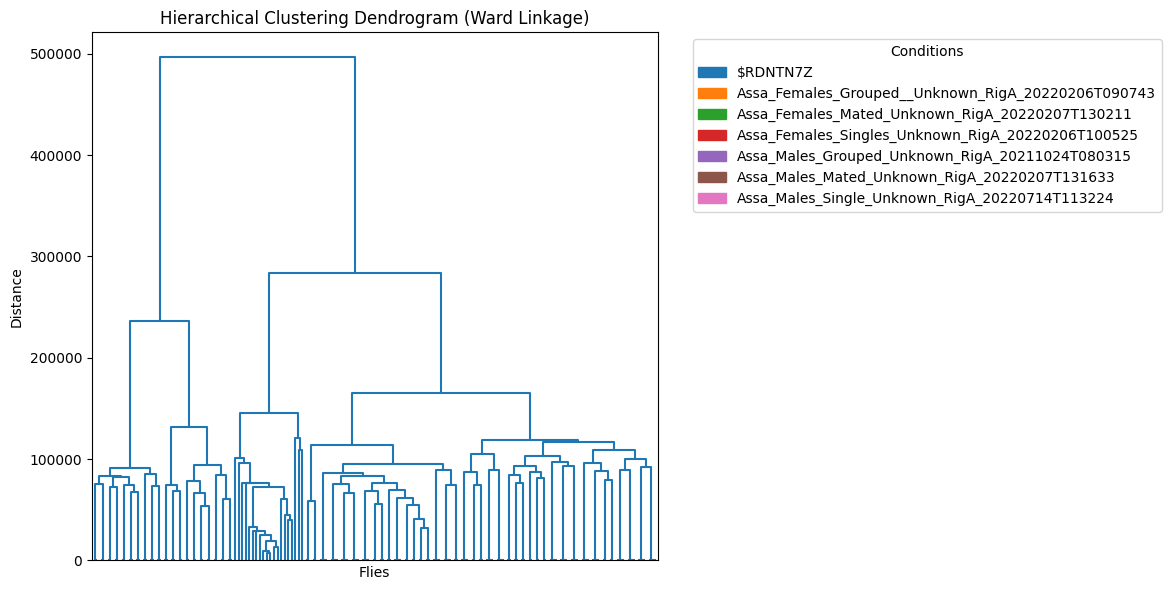

In [6]:
# ----------------------------------------------------
# 1) Hierarchical Clustering Visualization
# ----------------------------------------------------
plt.figure(figsize=(12, 6))

# Convert the distance matrix to condensed form for linkage
condensed_dist = squareform(dist_mat)

# Perform hierarchical clustering using Ward's method
Z = linkage(condensed_dist, method='ward')

# Plot the dendrogram without labels
dendrogram(
    Z,
    no_labels=True,
    color_threshold=0  # Disable default color thresholds
)

plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
plt.xlabel("Flies")
plt.ylabel("Distance")

# Create custom legend for conditions
legend_patches = [mpatches.Patch(color=condition_colors[cond], label=cond) for cond in unique_conditions]
plt.legend(handles=legend_patches, title="Conditions", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

ValueError: 'c' argument has 16 elements, which is inconsistent with 'x' and 'y' with size 160.

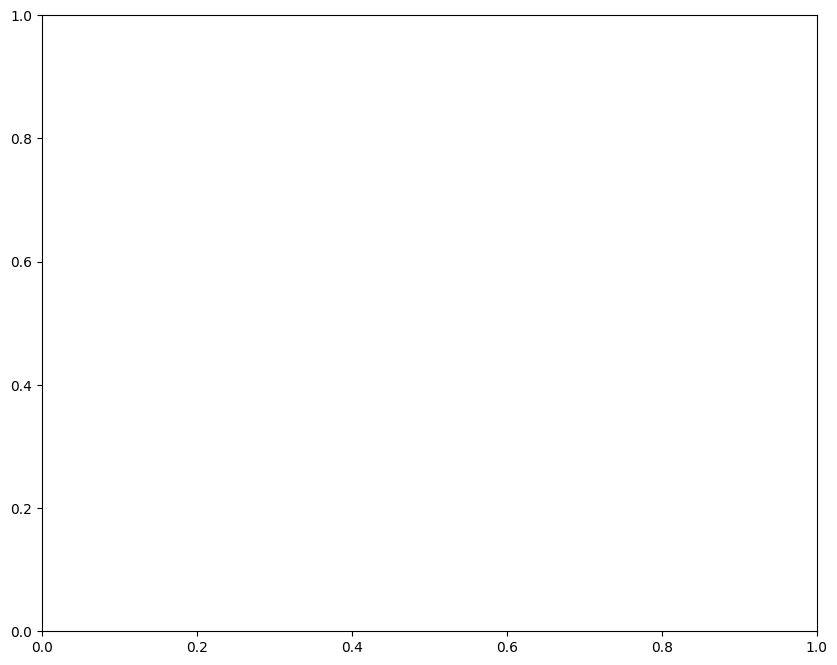

In [7]:
# ----------------------------------------------------
# 2) MDS Visualization of Distance Matrix
# ----------------------------------------------------
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(dist_mat)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=fly_colors, s=100, alpha=0.7)

# Optionally, annotate each point with its Fly ID
for i, label in enumerate(fly_labels):
    plt.text(coords[i, 0]+0.02, coords[i, 1]+0.02, label, fontsize=9)

plt.title("MDS Projection of Flies (Approach 1)")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)

# Create custom legend for conditions
plt.legend(handles=legend_patches, title="Conditions", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

D:\Users\Ilya\TimeSeriesDistance\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Users\Ilya\TimeSeriesDistance\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


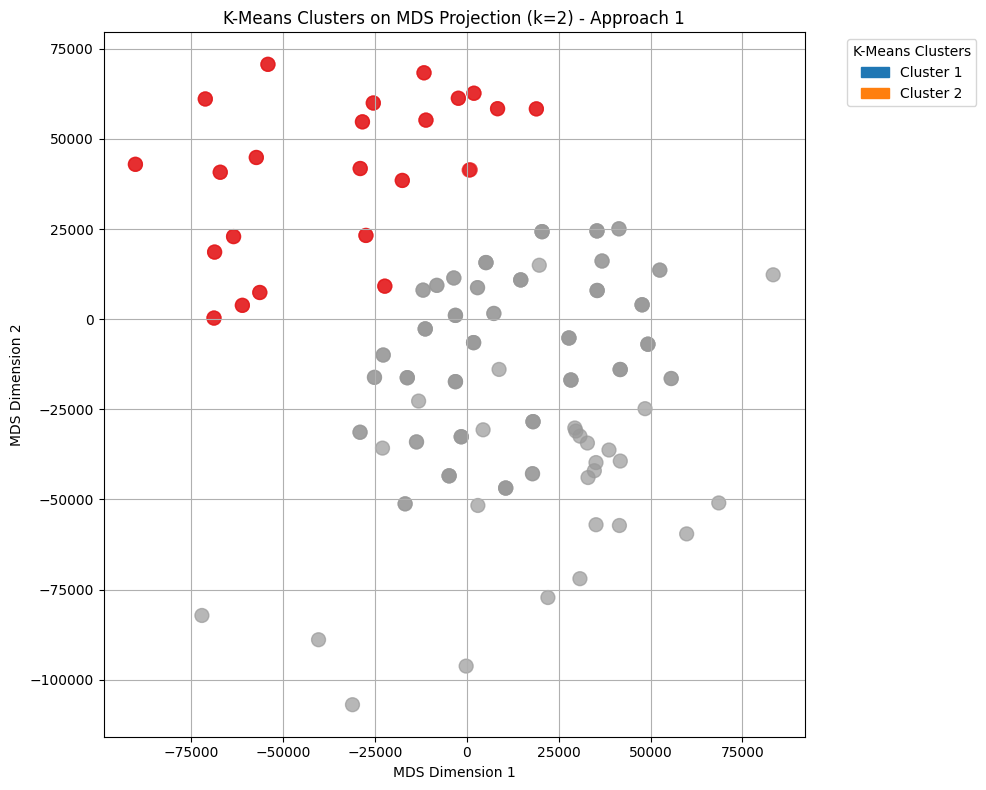

In [8]:
# ----------------------------------------------------
# 3) K-Means Clustering on MDS Coordinates
# ----------------------------------------------------

# Determine the optimal number of clusters using the Elbow Method (Optional)
# Here, we'll proceed with k=2 since there are two conditions
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(coords)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=cluster_labels, cmap='Set1', s=100, alpha=0.7)


plt.title(f"K-Means Clusters on MDS Projection (k={k}) - Approach 1")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True)

# Create legend for clusters
cluster_patches = [mpatches.Patch(color=cmap(i), label=f"Cluster {i+1}") for i in range(k)]
plt.legend(handles=cluster_patches, title="K-Means Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [17]:
print(dist_mat[1][21])

96222.0
